In [1]:
import torch

from deepmash.data_processing.constants import *
from deepmash.data_processing.common import get_dataloaders, ToLogMel, get_vocal_rms
from deepmash.data_processing.gtzan_stems import GTZANStemsDataset
from deepmash.data_processing.musdb18 import MUSDB18Dataset
from deepmash.models.cocola_cnn import CocolaCNN
from deepmash.utils.utils import get_device

# reload imported modules automatically (so you dont have to restart kernel when changing .py files)
%load_ext autoreload
%autoreload 2

/Users/valle/Library/CloudStorage/OneDrive-KTH/Dokument/KTH/musik-dt2470/deep-mash/.venv/lib/python3.13/site-packages/stempeg/__init__.py:30: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [2]:
ds_gtzan = GTZANStemsDataset(
    root_dir="datasets/gtzan-stems",
    already_preprocessed=False,
    preprocess_transform=ToLogMel(),
)

ds_musdb_train = MUSDB18Dataset(
    root_dir="datasets/musdb18",
    split="train",
    already_preprocessed=True,
    preprocess_transform=ToLogMel(),
)
ds_musdb_test = MUSDB18Dataset(
    root_dir="datasets/musdb18",
    split="test",
    already_preprocessed=True,
    preprocess_transform=ToLogMel(),
)

print(len(ds_gtzan), len(ds_musdb_train), len(ds_musdb_test))
print(ds_gtzan[42].vocals.shape, ds_musdb_train[42].vocals.shape)

Preprocessing stems from datasets/gtzan-stems to datasets/gtzan-stems-processed ...


  0%|          | 0/1000 [00:00<?, ?it/s]

/Users/valle/Library/CloudStorage/OneDrive-KTH/Dokument/KTH/musik-dt2470/deep-mash/.venv/lib/python3.13/site-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(


2000 1243 841
torch.Size([64, 751]) torch.Size([64, 751])


In [ ]:
# check vocal energy distribution
ds = ds_gtzan
vocal_energy = torch.tensor([get_vocal_rms(sample.vocals) for sample in ds])
print(vocal_energy.mean(), vocal_energy.std(), vocal_energy.min(), vocal_energy.max())
print((vocal_energy < 15).sum().item())

tensor(47.9143) tensor(27.0449) tensor(12.0872) tensor(100.)
0


In [6]:
# check that dataloaders and forward-pass works

ds = ds_gtzan

train_loader, val_loader, test_loader = get_dataloaders(
    dataset=ds,
    batch_size=16,
    val_split=0.1,
    test_split=0.1
)

device = get_device()
print(f"Using device: {device}")

model = CocolaCNN(learning_rate=0.001, embedding_dim=512, dropout_p=0.1)
model = model.to(device)

batch = next(iter(train_loader))
batch = batch.to(device)
print(batch.vocals.shape, batch.non_vocals.shape)

model(batch).shape

Using device: mps
torch.Size([16, 64, 751]) torch.Size([16, 64, 751])


torch.Size([16, 16])

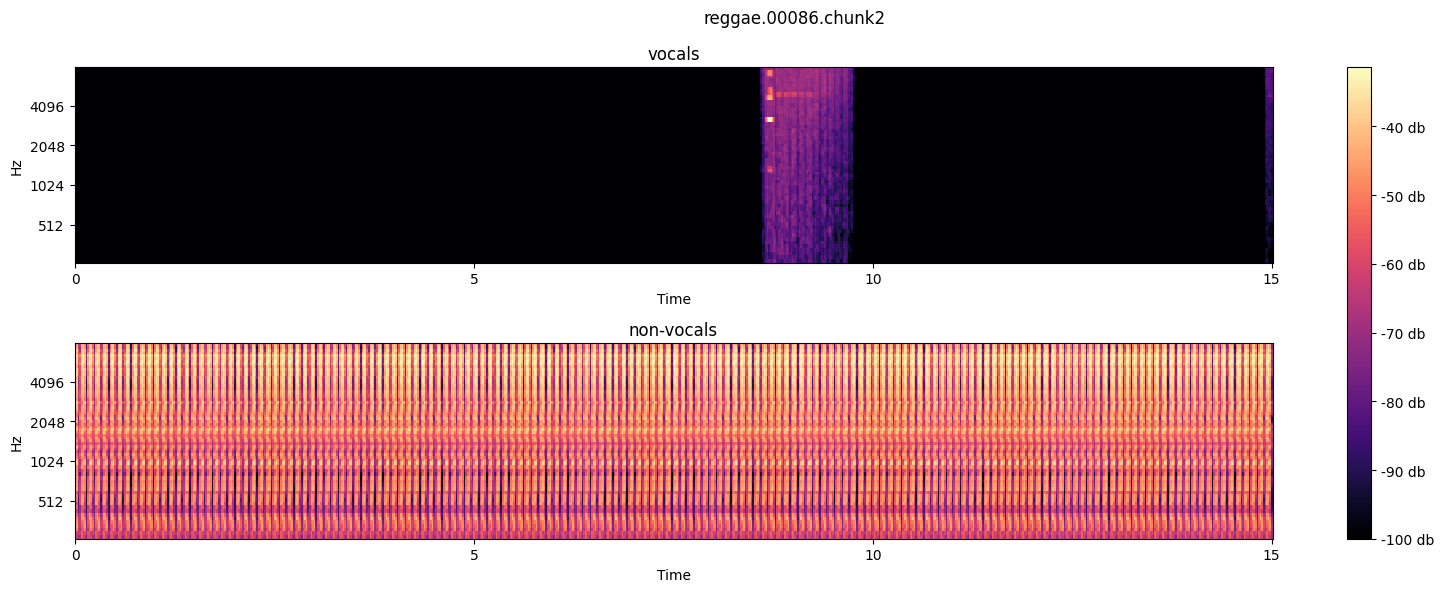

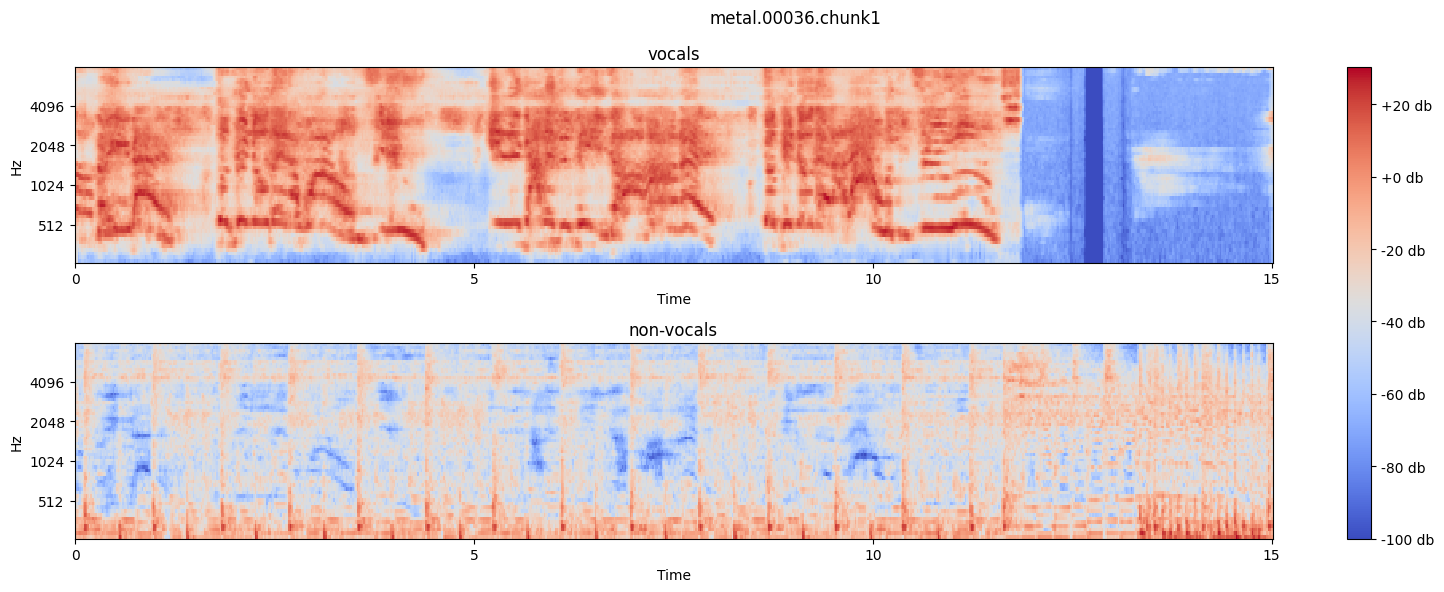

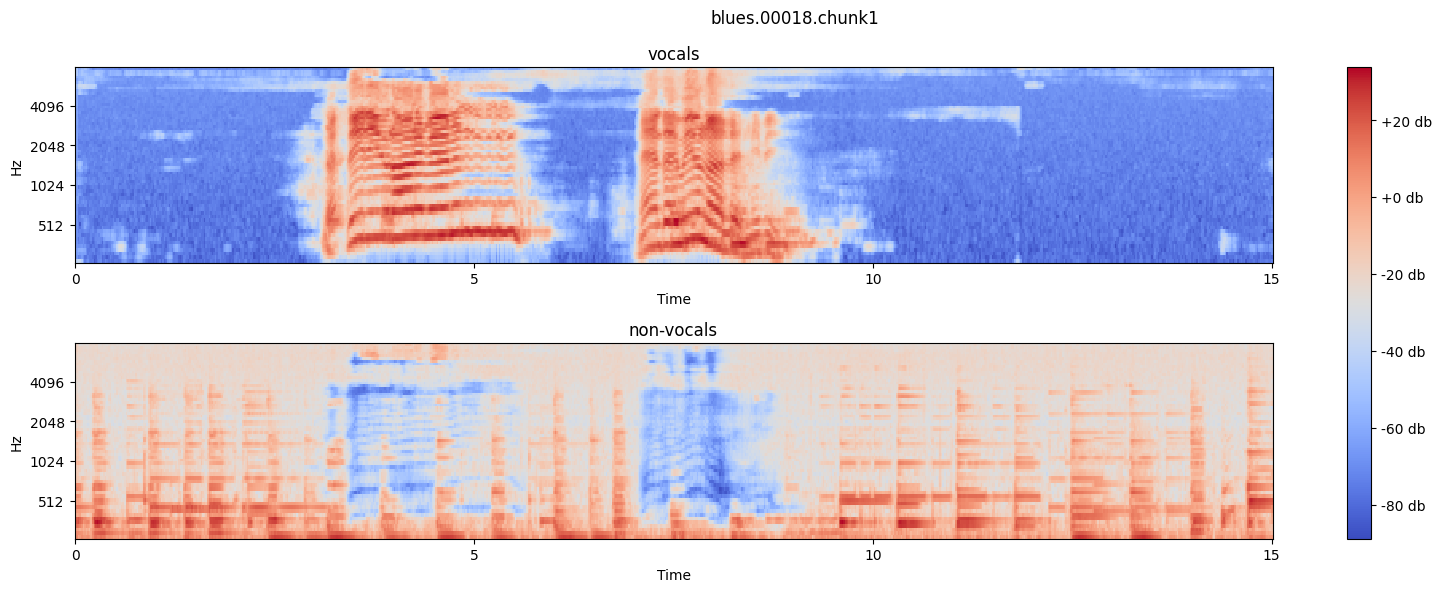

In [7]:
from deepmash.utils.plotting_utils import display_random_chunk

for _ in range(3):
    display_random_chunk(ds)